# Week 4 - Picking Loans using Regression of Loan Returns

This notebook carries out the following steps
  1. Reads the saved returns data from the pickle 
  2. Build several classifier and regression models with the data (Save the time-consuming models for loading in later re-runs)
  3. Uses the regressions for returns and the classification models from before for implementimg some simple strategies for picking loans to invest in. A new greedy strategy has been added but you should try others.
  4. Tests these strategies on a portfolio of 100 loans
  5. Performs a sensitivity analysis of the performance of the loan to the number of loans invested in from 100 to 1000
  6. (optional) Re-run the test strategies on different test and train sets from different time periods
      - `2013` & `2014`
  
Things for you to do
- Decide on one of the return columns to focus on and justify why. Note that you should do this BEFORE looking at the results of the regressions for predicting all the return columns to not get biased
- For the return column you picked, examine the various types of regularized regressions to pick the best regularized model, or simply use automated analysis to pick a subset of variables to include in a regular regression. You will need to finalize your best model before moving to the next step
- For the return column you picked, try various strategies for picking the best set of loans to invest in, using the ideas from the case. You should use the best model for the return column you picked here
- Interpret the results of the different strategies
- Vary the number of loans selected and see how it affects the results
- Think of a new rule to pick the best loans using the analyses you have done so far, and add it to the script. e.g. 
    - Rank by return but only accept if P(default) is not too high. 
    - If you want to go further, you can try to implement a two-stage model: First, estimate expected return in two stages: Stage 1 - default or not default, Stage 2 - resulting return given stage 1 state, and combine them using Pr(default) predicted from another classification model from last week
    
Prepare your **presentation**. Your presentation should contain about 5 to 6 slides. Add an extra slide at the end if you tried the BONUS.
1. Begin by stating the objective of the presentation and what your objective is. Which questions do you seek to answer? What are the main points of the presentation?
2. (3) Which method did you use to compute returns? Why? How did the different predictive model perform? Which metric are you using to evaluate the predictions? 
4.  Compare the different strategies to select loans based on the predictions obtained. Present a table containing the predicted return percentages. Which method do you think Alice should use? Which new strategy do you propose to select the loans? Does it perform better than the previous ones?
5. Include your robustness results. How do your strategies scale? Do your results change by changing the number of loans you are able to invest in? what if you have a limited budget? Does this affect the best strategy that you selected on the previous slide?
6.  State your conclusions. What is the main idea you wish to convey with the presentation? Do you think the findings from this script will be useful to solve the overall problem? What are the main takeways from the analysis you performed?

BONUS
- Is there correlation between higher predicted returns and probability of default (computed in module M3). If so, how can you exploit this to improve your models?
- Can you improve your models using the results from module 2? If so, clearly state the improvements in terms of the metric you used to evaluate your models.
- Can you derive new variables from the original ones to improve your models? If so, clearly state the improvements in terms of the metric you used to evaluate your models.
- Use a more sophisticated (although less interpretable) predictive model such as tree boosting or support vector machine to obtain new results. Do these models perform better?
- Are there any exogenous variables (i.e. variables from other data sets, such as economic growth of the country) you might use to improve your models?

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import collections

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.metrics import auc, precision_recall_curve, f1_score
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LassoLars

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Load debugger, if required
# --------------
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
# --------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ##  read saved models
# infile = open('./week4_saved_models','rb')
# saved_models = pickle.load(infile)
# models_to_save = saved_models.copy() # save new models in this new dict
# infile.close()
# print('models loaded:\n', saved_models.keys())

In [3]:
# You can also import a dill pickle with the whole session from before
# pip install ipython
# import dill
# dill.load_session('week4.pkl')

In [4]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [5]:
default_seed = 1
output_file = "output_test1"

In [6]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [7]:
# Read the data and features from the pickle
data, discrete_features, continuous_features, ret_cols = pickle.load( open("C:\\Users\\ly266e\\Documents\\Training\\CMU\\Master\\Fall 2023 Mini 7\\Business_Analytics\\HW\\HW5\\Update\\PickleData\\ret_data_selection.pickle", "rb" ) )

# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

In [8]:
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc,outcome,cr_hist,train
0,1,7200.0,7200.0,36 months,9.17,B,10+ years,MORTGAGE,50000.0,Not Verified,...,8.016592,36,0.018428,0.082755,0.023094,0.042427,0.078373,False,340.015195,True
1,2,12000.0,12000.0,36 months,9.17,B,4 years,MORTGAGE,39400.0,Not Verified,...,18.004476,36,0.035488,0.070958,0.032752,0.051051,0.084770,False,110.983798,False
2,3,8800.0,8800.0,36 months,9.80,B,10+ years,MORTGAGE,92000.0,Source Verified,...,20.008624,36,0.039882,0.071756,0.035290,0.053412,0.086748,False,168.972669,True
3,4,15000.0,15000.0,36 months,5.32,A,10+ years,MORTGAGE,44000.0,Source Verified,...,37.027454,36,0.028457,0.027667,0.026164,0.040551,0.066688,False,162.007433,True
4,5,6000.0,6000.0,36 months,7.49,A,10+ years,MORTGAGE,100000.0,Not Verified,...,37.027454,36,0.039539,0.038442,0.033092,0.047920,0.074857,False,259.027906,True


In [9]:
data_kmeans = data.copy()
data_kmeans['loan_status_binary'] = data_kmeans['outcome'].apply(lambda x: 1 if x == True else 0)
continuous_features_kmeans = continuous_features.copy()
continuous_features_kmeans.append('loan_status_binary')
data_kmeans = data_kmeans[['int_rate', 'annual_inc','loan_amnt', 'dti','inq_last_6mths', 'open_acc', 'total_pymnt']]

In [10]:
df_st =  StandardScaler().fit_transform(data_kmeans) # this is an array

# see few rows of standardized dataset
pd.DataFrame(df_st, columns=data_kmeans.columns).head()

,int_rate,annual_inc,loan_amnt,dti,inq_last_6mths,open_acc,total_pymnt
0,-0.787161,-0.602532,-0.926394,0.004132,-0.680974,0.280068,-0.826882
1,-0.787161,-0.896466,-0.350107,0.821167,0.619300,1.274037,-0.280224
2,-0.639500,0.562112,-0.734298,-1.621849,0.619300,-0.515106,-0.609853
3,-1.689533,-0.768910,0.010072,-0.447722,0.619300,-0.912694,0.008817
4,-1.180924,0.783949,-1.070465,-0.685783,0.619300,-0.515106,-0.912193


In [11]:
K=3
kmeans = KMeans(n_clusters=K, random_state=10).fit(df_st)
labels = kmeans.labels_
collections.Counter(labels) # show the number of occurences of each of the labels

Counter({2: 162644, 0: 129075, 1: 108563})

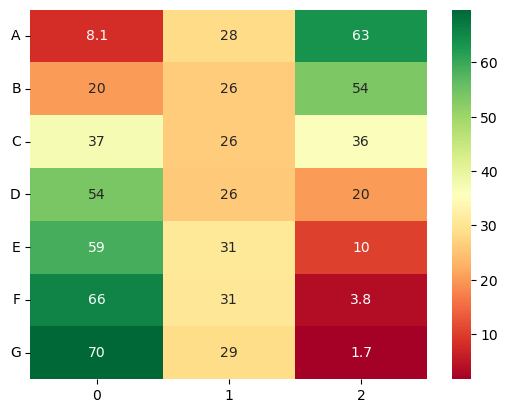

In [12]:
grade =  data.grade.to_numpy() # np_array
K=3
ltr2num = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
table = np.zeros([7,K]) # row = letter grade, column = kmeans label
for j in range(df_st.shape[0]):
    table[ltr2num[grade[j]], labels[j]]+=1 # confusion matrix
for i in range(7):
    table[i,:] = np.round(table[i,:]*100/table[i,:].sum(), 1)

df_temp = pd.DataFrame(table, columns = [0,1,2])
# visulaize confusion matrix using heatmap
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.heatmap(df_temp, annot=True, cmap='RdYlGn',  yticklabels=grades)
plt.yticks(rotation=0, ha='right')  # ha is the horizontal alignment
plt.show()

In [13]:
data['kmeans'] = labels

In [14]:
continuous_features

['loan_amnt',
 'funded_amnt',
 'annual_inc',
 'dti',
 'revol_bal',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'inq_last_6mths',
 'int_rate',
 'revol_util',
 'pct_tl_nvr_dlq',
 'cr_hist']

In [15]:
discrete_features.remove('grade')

In [16]:
#Continuous
features_to_remove = ['funded_amnt'] #I cannot be removed until now
continuous_features = [feature for feature in continuous_features if feature not in features_to_remove]

In [17]:
columns_to_remove = ['home_ownership_RENT', 'purpose_credit_card', 'purpose_house', 'home_ownership_OTHER', 'cr_hist', 'verification_status_Verified']

In [18]:
# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
discrete_features_dummies = [feature for feature in discrete_features_dummies if feature not in columns_to_remove]
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [19]:
def prepare_data_imb(data_subset = np.array([True]*len(data)),
                          n_samples_train = 20000,
                          n_samples_test = 10000,
                          feature_subset = None,
                          date_range_train = (data.issue_d.min(), data.issue_d.max()),
                          date_range_test = (data.issue_d.min(), data.issue_d.max()),
                          random_state = default_seed):
    
    np.random.seed(random_state)
    
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum() 
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum() 
                                   - n_samples_test, replace = False ) ] = False
    
    # Get training data and labels
    X_temp_train = X[filter_train, :]
    y_temp_train = y[filter_train]
    
    # Separate majority and minority classes
    X_majority = X_temp_train[y_temp_train == False]
    X_minority = X_temp_train[y_temp_train == True]
    y_majority = y_temp_train[y_temp_train == False]
    y_minority = y_temp_train[y_temp_train == True]
    
    # Downsample majority class
    X_majority_downsampled = X_majority[:len(X_minority)]
    y_majority_downsampled = y_majority[:len(y_minority)]
    
    # Combine minority class with downsampled majority class
    X_train_balanced = np.vstack((X_majority_downsampled, X_minority))
    y_train_balanced = np.hstack((y_majority_downsampled, y_minority))
    
    # Prepare the test set
    X_test = X[filter_test, :]
    y_test = y[filter_test]
    
    # Feature selection if specified
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train_balanced = X_train_balanced[:, cols]
        X_test = X_test[:, cols]
        
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()
    X_train_balanced = scaler.fit_transform(X_train_balanced)
    X_test = scaler.transform(X_test)
    
    out = {'X_train': X_train_balanced, 'y_train': y_train_balanced, 'train_set': filter_train, 
           'X_test': X_test, 'y_test': y_test, 'test_set': filter_test}
    
    return out

In [20]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
#     tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
#     if print_to_screen:
#         print("")
#         print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Feature preparation

In [21]:
# final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]
final_features = [i for i in discrete_features + continuous_features]
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]

## useful when choosing the most significant features
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [22]:
## Process data here:
data_dict1213 = prepare_data_imb(data_subset = np.array([True]*len(data)), feature_subset = final_features)

In [23]:
# Checking the number of Trues and Falses in the y_train from the provided data dictionary
true_count = np.sum(data_dict1213['y_train'])
false_count = len(data_dict1213['y_train']) - true_count
true_count, false_count

(3779, 3779)

### $l_1$ penalized logistic regression

  Model: l1 Penalized Logistic Regression
Fit time: 125.74 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.4962808592962882
Accuracy:  0.6396
              precision    recall  f1-score   support

  No default     0.8881    0.6342    0.7400      8087
     Default     0.2999    0.6623    0.4128      1913

    accuracy                         0.6396     10000
   macro avg     0.5940    0.6483    0.5764     10000
weighted avg     0.7756    0.6396    0.6774     10000



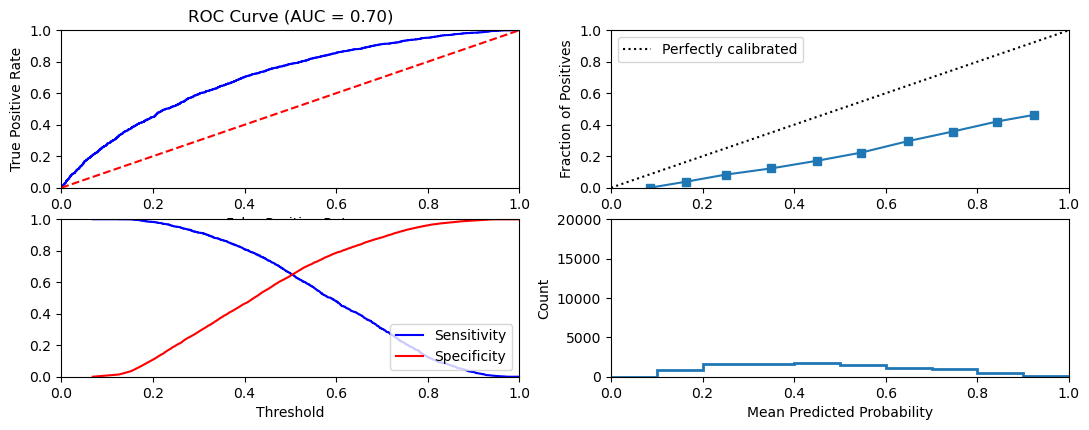

Brier score: 0.22459942403957392
Were parameters on edge? : True
Score variations around CV search grid : 0.2166182223074837
[0.67174127 0.67041834 0.67028616 0.67081552 0.67081552 0.67068324
 0.67068324 0.67068324 0.67068324 0.67068324]


In [24]:
# # Read models saved in a dictionary
# l1_logistic1213 = saved_models['l1_logistic1213']

#Run the following the first time through
l1_logistic = LogisticRegression(penalty = 'l1',solver='saga', max_iter=10000, n_jobs=-1)
cv_parameters = {"C":np.logspace(0, 6, num = 10)}
l1_logistic1213 = fit_classification(l1_logistic, data_dict1213,
                      cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression")

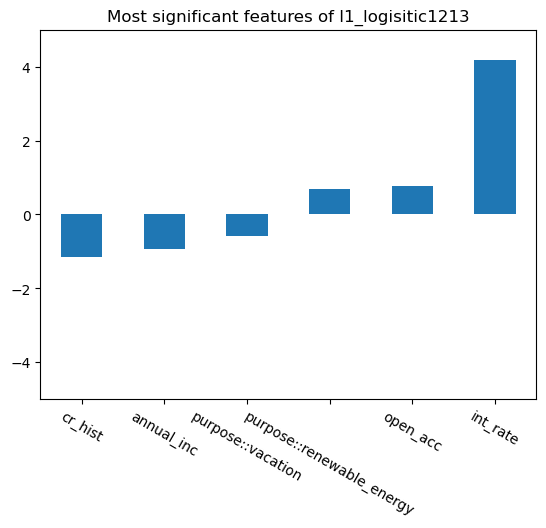

In [25]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l1_logistic1213['model'].coef_)[0,:3]) + list(np.argsort(l1_logistic1213['model'].coef_)[0,-3:])
bplot = pd.Series(l1_logistic1213['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,5))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l1_logisitic1213')
plt.show()

# Build and Test Regression Models for returns

In [26]:
def prepare_data_all(data_subset = np.array([True]*len(data)),
                    n_samples_train = 20000,
                    n_samples_test = 10000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that rowFdecisipn
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
    
    # Filter down the data to the required date range, and downsample
    # as required
#     print("sizes:", train.shape[0], data.shape[0], data_subset.shape[0])
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum() 
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum() 
                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [27]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False,
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']

    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}

    for ret_col in col_list:

        #y_train = data.loc[filter_train, ret_col].as_matrix()
        #y_test = data.loc[filter_test, ret_col].as_matrix()
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_

            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)

            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_

            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

## Run regression models on all data

#### Note:
In this section of the code we will run different regressions depending on the K Means Values

In [28]:
data_dict1213_reg = prepare_data_all(data_subset = np.array([True]*len(data)), feature_subset = final_features)

In [29]:
# Checking the number of Trues and Falses in the y_train from the provided data dictionary
true_count = np.sum(data_dict1213_reg['y_train'])
false_count = len(data_dict1213_reg['y_train']) - true_count
true_count, false_count

(3779, 16221)

### Lasso-Lars regressor

In [30]:
# First, trying LASSO penalized regression with a variety of parameters,
# it becomes clear a simple regression is best

cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }
reg_lasso1213 = fit_regression(linear_model.LassoLars(), data_dict1213_reg,  
               cv_parameters = cv_parameters, separate = False, model_name = "Lasso")

  Model: Lasso  Return column: ret_PESS
Fit time: 0.57 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: 0.008001868419107105
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 104.90381551494552
All test scores : [ 0.00653817  0.00664225  0.00708416  0.00730483 -0.00035822 -0.00035822
 -0.00035822 -0.00035822]
  Model: Lasso  Return column: ret_OPT
Fit time: 0.56 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: 0.015113019629483082
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 101.88643697557765
All test scores : [ 0.01802896  0.01810315  0.01843355  0.01862097 -0.00035127 -0.00035127
 -0.00035127 -0.00035127]
  Model: Lasso  Return column: ret_INTa
Fit time: 0.55 seconds
Optimal parameters:
{'alpha': 1e-06}

Testing r2 score: 0.015787931019314083
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 102.34933591946108
All test scores : [ 0.0

# Test investment strategies
Now we test several investment strategies using the learning models above

In [31]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random',
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns.
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.

    It is currently able to test four strategies
      - random: invest in a random set of loans
      - ranking: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - regression: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - two-stage: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
      - knapsack: 

    It expects the following parameters
      - data: the data set we are using now
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file

    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''

    np.random.seed(random_state)

    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']

    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}

    for ret_col in col_list:

        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Regression':

            colname = 'predicted_return_' + ret_col

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Ranking':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Two-stage':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col

            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return +
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Greedy':

            # Sort the loans by return-to-risk ratio:
            temp1 = regressor["ret_INTc"]['predicted_return']
            #temp1 = data_test.ret_INTc.to_numpy() # return
            temp2 = data_test['score'].to_numpy() # default probability
            data_test['ratio'] = temp1/temp2
            data_test = data_test.sort_values(by='ratio', ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        elif strategy == 'KMeans':
            
            # Extract unique kmeans values
            kmeans_values = data_test['kmeans'].unique()

            for kmean_val in kmeans_values:

                # Subset data based on current kmean value
                data_subset = data_test[data_test['kmeans'] == kmean_val].copy()

                # Reset the index of the subset for direct indexing
                data_subset.reset_index(drop=True, inplace=True)

                # Filter the predicted returns to match the data_subset length
                predicted_regular_return_subset = regressor[ret_col]['predicted_regular_return'][data_subset.index]
                predicted_default_return_subset = regressor[ret_col]['predicted_default_return'][data_subset.index]

                # Load the predicted returns
                data_subset['predicted_regular_return'] = predicted_regular_return_subset
                data_subset['predicted_default_return'] = predicted_default_return_subset

                # Compute expectation
                colname = 'predicted_return_' + ret_col

                data_subset[colname] = ((1-data_subset.score) * data_subset.predicted_regular_return +
                                        data_subset.score * data_subset.predicted_default_return)

                # Sort the loans by predicted return
                data_subset = data_subset.sort_values(by=colname, ascending = False).reset_index(drop = True)

                # Pick num_loans loans
                pf_test = data_subset[['funded_amnt',ret_col]].iloc[:num_loans]

                # Find their return
                ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

                # Return
                out_key = ret_col + "_kmean_" + str(kmean_val)  # Use a unique key for each kmean value
                out[out_key] = {'strategy':strategy, 'kmean':kmean_val, 'average return':ret_test, 'test data':data_subset}

                # Dump the strategy performance to file
                if output_to_file:
                    dump_to_output(strategy + "," + ret_col + "_kmean_" + str(kmean_val) + "::average return", ret_test)

            continue

        elif strategy == 'Crystal-ball':

            # Sort the loans by realized return
            data_test = data_test.sort_values(by=ret_col, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'

    return out

In [32]:
train_set = data_dict1213_reg['train_set']
test_set = data_dict1213_reg['test_set']
# Create a dataframe for testing, including the score
data_test1 = data.loc[test_set,:]

# Implement the test strategies

### Random  

In [33]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_random = test_investments(data_dict1213_reg, strategy = test_strategy, 
                            num_loans = 100, output_to_file = False, random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_random[ret_col]['average return']))

strategy: Random
ret_PESS: 0.025517316499435585
ret_OPT: 0.03645010555874237
ret_INTa: 0.013374979515269631
ret_INTb: 0.046586956277858006
ret_INTc: 0.07143974706616202


### Ranking  

In [34]:
# load the random forest model if you haven't yet
#rf1213 = saved_models['rf1213']

test_strategy = 'Ranking'

print('strategy:',test_strategy)
strat_rank = test_investments(data_dict1213_reg, classifier=l1_logistic1213, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy: Ranking
ret_PESS: 0.024931554055620943
ret_OPT: 0.051821563139005614
ret_INTa: 0.02029138235585105
ret_INTb: 0.043822488538011364
ret_INTc: 0.0689779190092415


### Regression    

In [35]:
# load the random forest model if you haven't yet
#reg_rf1213 = saved_models['reg_rf1213']

test_strategy = 'Regression'

print('strategy:',test_strategy)
strat_reg = test_investments(data_dict1213_reg, regressor = reg_lasso1213, strategy = test_strategy, 
                        num_loans = 100)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_reg[ret_col]['average return']))

strategy: Regression
ret_PESS: 0.025188792266778143
ret_OPT: 0.05135253007093056
ret_INTa: 0.040044882073818816
ret_INTb: 0.0481181953603318
ret_INTc: 0.0746716424560525


### Two Stage Model  

In [36]:
# First, trying LASSO penalized regression with a variety of parameters,
# it becomes clear a simple regression is best

cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }
reg_separate1213 = fit_regression(linear_model.LassoLars(), data_dict1213_reg,  
               cv_parameters = cv_parameters, separate = True, model_name = "Lasso")

  Model: Lasso  Return column: ret_PESS
Fit time: 0.68 seconds
Optimal parameters:
model_0: {'alpha': 1e-06} model_1 {'alpha': 0.0001}

Testing r2 scores:
model_0: 0.3668936690591915
model_1: 0.07324528770848937
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : 100.89677494166688
All test scores : [ 0.36316427  0.36319329  0.36385906  0.35430222  0.12941001 -0.003263
 -0.003263   -0.003263  ]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : 103.73178877393309
All test scores : [ 0.06346026  0.06346026  0.06472305  0.07048438  0.07082346 -0.00264298
 -0.00264298 -0.00264298]
  Model: Lasso  Return column: ret_OPT
Fit time: 0.69 seconds
Optimal parameters:
model_0: {'alpha': 1e-06} model_1 {'alpha': 0.0001}

Testing r2 scores:
model_0: 0.6956056415193395
model_1: 0.07135211045910772
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : 100.32504266205642
All test 

In [37]:
# data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

In [38]:
test_strategy = 'Two-stage'

print('strategy:',test_strategy)
two_stage = test_investments(data_dict1213_reg, classifier = l1_logistic1213, regressor = reg_separate1213, 
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

strategy: Two-stage
ret_PESS: 0.030371170781347212
ret_OPT: 0.05235825755990171
ret_INTa: 0.028122852078659322
ret_INTb: 0.049328970799668165
ret_INTc: 0.06868868238475838


### New Greedy Rule: sort the loans by return-to-risk ratio. 

In [39]:
test_strategy = 'Greedy'
print('strategy:',test_strategy)
strat_rank = test_investments(data_dict1213_reg, classifier = l1_logistic1213,regressor = reg_lasso1213, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy: Greedy
ret_PESS: 0.02517102271947714
ret_OPT: 0.04969796447771083
ret_INTa: 0.032463112005659094
ret_INTb: 0.0554316295519307
ret_INTc: 0.07475021349842688


### New KMeans Model

In [40]:
test_strategy = 'KMeans'
print('strategy:', test_strategy)
kmeans_strategy = test_investments(data_dict1213_reg, classifier = l1_logistic1213, regressor = reg_separate1213, 
                             strategy = test_strategy, num_loans = 100)

strategy: KMeans


In [41]:
kmeans_strategy

{'ret_PESS_kmean_1': {'strategy': 'KMeans',
  'kmean': 1,
  'average return': 0.02783059651648578,
  'test data':           id  loan_amnt  funded_amnt        term  int_rate grade emp_length  \
  0      45834    25000.0      25000.0   36 months      6.24     A     1 year   
  1     110685    20000.0      20000.0   36 months      9.17     B    3 years   
  2      59112    21000.0      21000.0   36 months      7.26     A  10+ years   
  3      29478    22000.0      22000.0   36 months      6.89     A  10+ years   
  4     193782    25000.0      25000.0   36 months      5.32     A     1 year   
  ...      ...        ...          ...         ...       ...   ...        ...   
  2673  303394    30000.0      30000.0   60 months     24.99     F  10+ years   
  2674  297917    23125.0      23125.0   60 months     25.89     G  10+ years   
  2675   11983    25200.0      25200.0   60 months     25.99     F    6 years   
  2676  148179    33000.0      33000.0   60 months     26.77     G    8 years 

In [42]:
# Extract unique kmeans values from the test data
test_data_subset = data.loc[data_dict1213_reg['test_set']]
kmeans_values = test_data_subset['kmeans'].unique()

# Loop through each return column
for ret_col in col_list:
    for kmean_val in kmeans_values:
        key = ret_col + "_kmean_" + str(kmean_val)
        if key in kmeans_strategy:
            print(key + ': ' + str(kmeans_strategy[key]['average return']))

ret_PESS_kmean_1: 0.02783059651648578
ret_PESS_kmean_2: 0.02138525084030103
ret_PESS_kmean_0: 0.023041306599051365
ret_OPT_kmean_1: 0.044080069269750013
ret_OPT_kmean_2: 0.03617192866015689
ret_OPT_kmean_0: 0.03465918990803711
ret_INTa_kmean_1: 0.029660314029012223
ret_INTa_kmean_2: 0.022434018213444148
ret_INTa_kmean_0: 0.02650857252190561
ret_INTb_kmean_1: 0.045345882054064035
ret_INTb_kmean_2: 0.038488542411216006
ret_INTb_kmean_0: 0.042496884675224035
ret_INTc_kmean_1: 0.07426939194360624
ret_INTc_kmean_2: 0.06779702465530894
ret_INTc_kmean_0: 0.0712890028356082


# Step 6-  Sensitivity test of portfolio size

In [43]:
import matplotlib.pyplot as plt

result_sensitivity = []

# Vary the portfolio size from 10 to 300 in increments of 10
for num_loans in list(range(10,500,10)):
    reg_0 = test_investments(data_dict1213_reg, regressor=reg_separate1213, classifier=l1_logistic1213, 
                             strategy='Two-stage', num_loans=num_loans)
    result_sensitivity.append(reg_0['ret_INTc']['average return'])

result_sensitivity = np.array(result_sensitivity) * 100

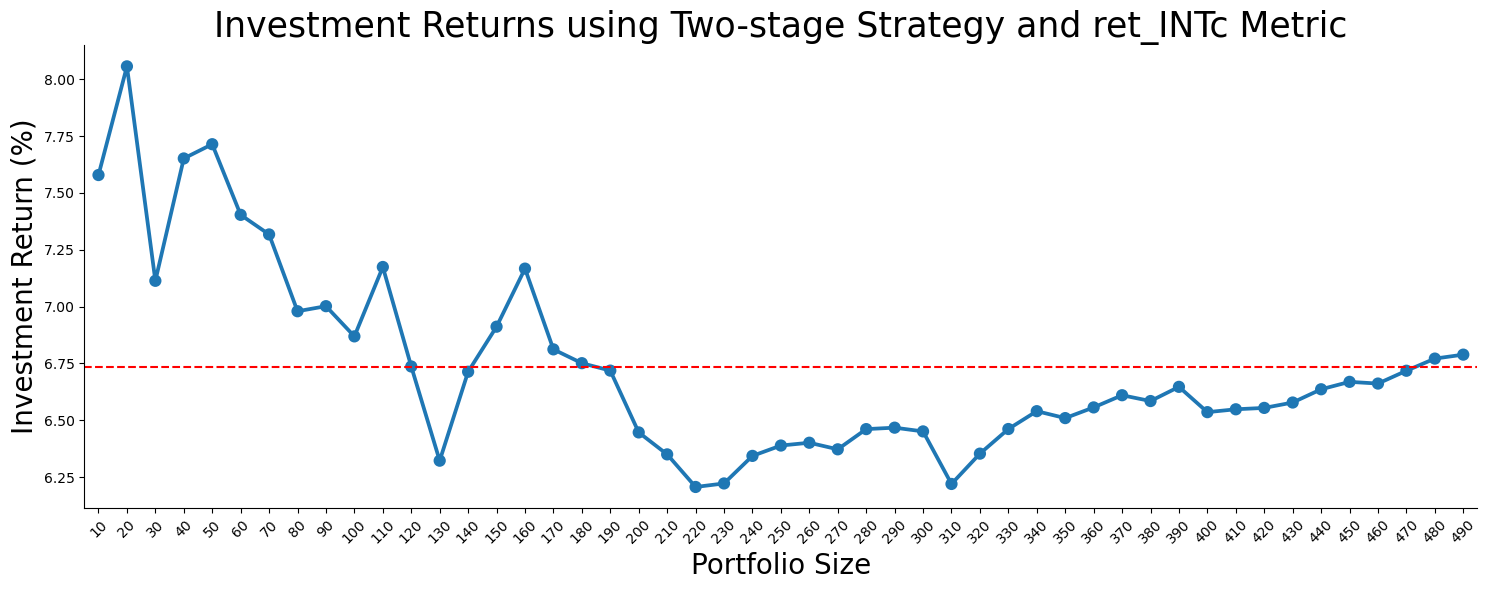

In [44]:
# Set the figure size (width, height) in inches
plt.figure(figsize=(15, 6))

# Plot using seaborn
sns.pointplot(x=np.array(list(range(10, 500, 10))), y=result_sensitivity)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a red dotted line for the average return
average_return = np.mean(result_sensitivity)
plt.axhline(y=average_return, color='red', linestyle='--', label=f"Average Return: {average_return:.2f}%")

# Remove top and right borders
sns.despine()

# Set y-axis and x-axis labels with font size
plt.ylabel('Investment Return (%)', size=20)
plt.xlabel('Portfolio Size', size=20)

# Add title to the plot
plt.title("Investment Returns using Two-stage Strategy and ret_INTc Metric", size=25)

# Display the plot
plt.tight_layout()
plt.show()

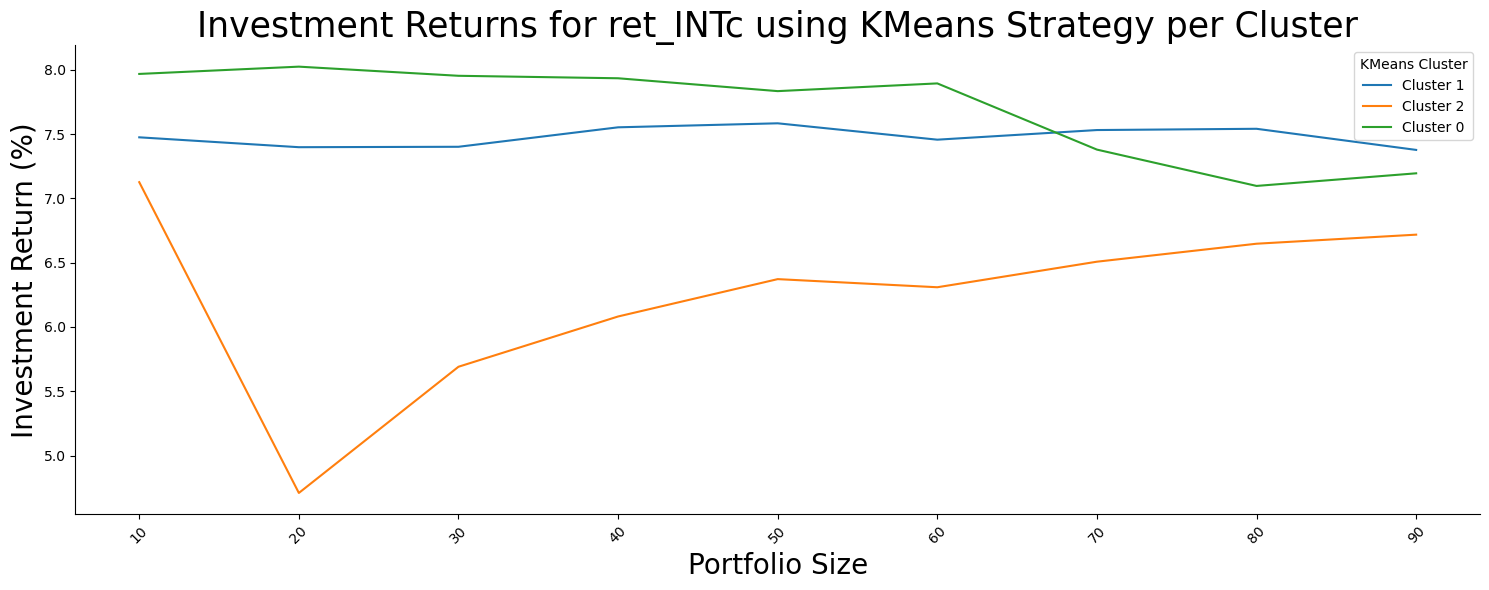

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Portfolio sizes to test
portfolio_sizes = list(range(10, 100, 10))

# Storing average returns for each kmean cluster
returns_per_cluster = {}

# Loop through portfolio sizes
for num_loans in portfolio_sizes:
    
    # Get investment results using the 'KMeans' strategy
    kmeans_results = test_investments(data_dict1213_reg, classifier=l1_logistic1213, regressor=reg_separate1213, 
                                      strategy='KMeans', num_loans=num_loans)
    
    # Loop through each kmeans cluster for ret_INTc
    for key in kmeans_results:
        if "ret_INTc_kmean" in key:
            cluster_num = key.split("_")[-1]
            if cluster_num not in returns_per_cluster:
                returns_per_cluster[cluster_num] = []
            returns_per_cluster[cluster_num].append(kmeans_results[key]['average return'] * 100)

# Plotting
plt.figure(figsize=(15, 6))

# Plot each cluster's returns
for cluster_num, returns in returns_per_cluster.items():
    sns.lineplot(x=portfolio_sizes, y=returns, label=f"Cluster {cluster_num}")

# Customize the plot
plt.xticks(rotation=45)
sns.despine()
plt.ylabel('Investment Return (%)', size=20)
plt.xlabel('Portfolio Size', size=20)
plt.title("Investment Returns for ret_INTc using KMeans Strategy per Cluster", size=25)
plt.legend(title="KMeans Cluster")
plt.tight_layout()
plt.show()

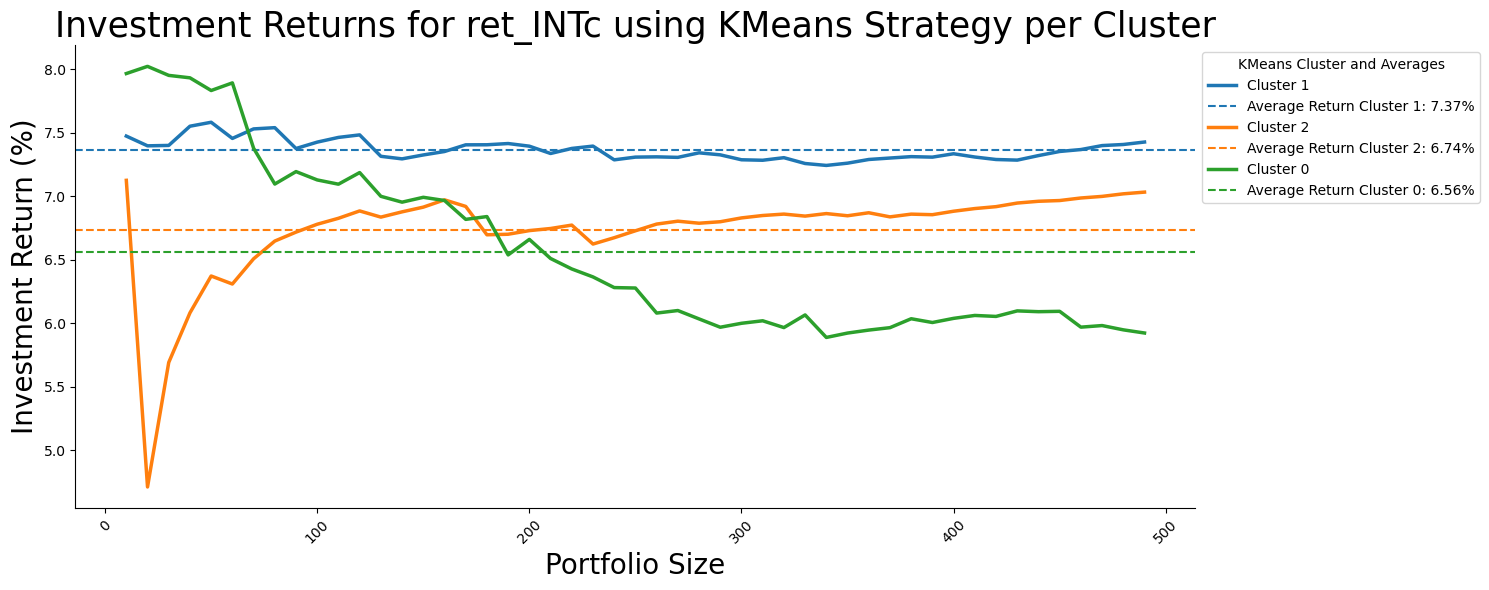

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Portfolio sizes to test
portfolio_sizes = list(range(10, 500, 10))

# Storing average returns for each kmean cluster
returns_per_cluster = {}

# Loop through portfolio sizes
for num_loans in portfolio_sizes:
    
    # Get investment results using the 'KMeans' strategy
    kmeans_results = test_investments(data_dict1213_reg, classifier=l1_logistic1213, regressor=reg_separate1213, 
                                      strategy='KMeans', num_loans=num_loans)
    
    # Loop through each kmeans cluster for ret_INTc
    for key in kmeans_results:
        if "ret_INTc_kmean" in key:
            cluster_num = key.split("_")[-1]
            if cluster_num not in returns_per_cluster:
                returns_per_cluster[cluster_num] = []
            returns_per_cluster[cluster_num].append(kmeans_results[key]['average return'] * 100)

# Plotting
plt.figure(figsize=(15, 6))

# Colors for each cluster's returns
colors = sns.color_palette("tab10", len(returns_per_cluster))

# Plot each cluster's returns
for i, (cluster_num, returns) in enumerate(returns_per_cluster.items()):
    sns.lineplot(x=portfolio_sizes, y=returns, label=f"Cluster {cluster_num}", color=colors[i], linewidth=2.5)
    
    # Plot average return for this cluster
    avg_return = np.mean(returns)
    plt.axhline(y=avg_return, color=colors[i], linestyle='--', label=f"Average Return Cluster {cluster_num}: {avg_return:.2f}%")

# Customize the plot
plt.xticks(rotation=45)
sns.despine()
plt.ylabel('Investment Return (%)', size=20)
plt.xlabel('Portfolio Size', size=20)
plt.title("Investment Returns for ret_INTc using KMeans Strategy per Cluster", size=25)
plt.legend(title="KMeans Cluster and Averages", loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

## Save the models in one file. or save the whole session in a dill file
Some of the models take long time to train. You may put your models in a dictionary and save it by running: 

In [47]:
# save all time-consuming models in one dict_ 
models_to_save = {}
models_to_save['reg_lasso1213'] = reg_lasso1213
models_to_save['reg_separate1213'] = reg_separate1213
models_to_save['l1_logistic1213'] = l1_logistic1213

In [48]:
# os.path.abspath(os.getcwd()) # get current directory
filename = './week4_saved_models'
outfile = open(filename,'wb')
pickle.dump(models_to_save, outfile)
outfile.close()

In [49]:
# Save the whole session as a dill file
# !conda install dill -y
# import dill
# dill.dump_session('week4.pkl')

#The above command dumps a file in the current directory which you can load later as follows
# import dill
# dill.load_session('week4.pkl')